In [1]:
import json
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA, SPSA, QNSPSA, CG, AQGD, ADAM
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

from qiskit_ibm_provider import IBMProvider
#from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

IBMProvider.save_account('44bd61e1f058fcb72f1964575350ac3254b97ab79d72e4b0744e598d30c1d12fd9464bc451621a4e53e106a693dad63565d58cfd1a0af8150addef5329b428e7', overwrite=True)

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.decomposition import PCA, SparsePCA, KernelPCA

import seaborn as sns

In [2]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('MiniBooNE.arff')
data = data[0]
df = pd.DataFrame(data)

df.head()

,signal,ParticleID_0,ParticleID_1,ParticleID_2,ParticleID_3,ParticleID_4,ParticleID_5,ParticleID_6,ParticleID_7,ParticleID_8,...,ParticleID_40,ParticleID_41,ParticleID_42,ParticleID_43,ParticleID_44,ParticleID_45,ParticleID_46,ParticleID_47,ParticleID_48,ParticleID_49
0,b'True',2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,...,101.174,-31.3730,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996
1,b'True',3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,...,186.516,45.9597,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621
2,b'True',3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,...,129.931,-11.5608,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901
3,b'True',4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,...,163.978,-18.4586,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990
4,b'True',5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,...,229.555,42.9600,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893


In [3]:
features = df.drop('signal', axis=1)
labels = df['signal']

labels_new = []  

for i in range(len(labels)):
    if labels[i] == b'True':
        labels_new.append(1)
    else:
        labels_new.append(0)
        
labels_new = np.array(labels_new)

In [4]:
feature_space = 5

features = StandardScaler().fit_transform(features)

features = PCA(n_components=feature_space).fit_transform(features)

In [5]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels_new, train_size=0.7, random_state=algorithm_globals.random_seed)

In [6]:
train_features, test_features, train_labels, test_labels = train_features[:7000], test_features[:3000], train_labels[:7000], test_labels[:3000]

In [7]:
def evaluate(y_test,y_pred,y_pred_proba):
    cnf_matrix=metrics.confusion_matrix(y_test,y_pred)
    print('The confusion matrix for the given model is: ')
    print(cnf_matrix)
    print('accuracy : ',metrics.accuracy_score(y_test,y_pred))
    print('precision : ',metrics.precision_score(y_test,y_pred))
    print('recall : ',metrics.recall_score(y_test,y_pred))
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr,tpr,label='Area under the curve= '+str(auc))
    plt.legend(loc=4)
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True Positive rate')

In [8]:
from sklearn.svm import SVC

start = time.time()
svc = SVC(probability=True)
_ = svc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 2 seconds


In [9]:
train_score_c = svc.score(train_features, train_labels)
test_score_c = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c:.2f}")

Classical SVC on the training dataset: 0.87
Classical SVC on the test dataset:     0.87


The confusion matrix for the given model is: 
[[2083  121]
 [ 270  526]]
accuracy :  0.8696666666666667
precision :  0.8129829984544049
recall :  0.6608040201005025


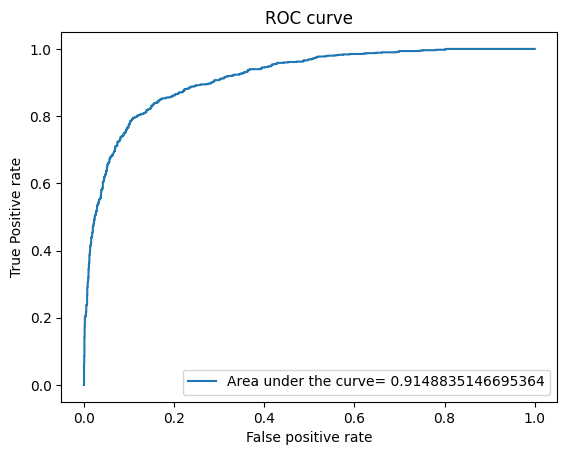

In [10]:
c_y_pred = svc.predict(test_features)
c_y_pred_proba = svc.predict_proba(test_features)[::,1]

# evaluate the model
evaluate(test_labels, c_y_pred, c_y_pred_proba)

### VQC

#### Angle Encoding

In [11]:
num_features = features.shape[1]

params = ParameterVector("input", feature_space)
qc_angle = QuantumCircuit(feature_space)

qc_angle.ry(params[0], [0])
qc_angle.ry(params[1], [1])
qc_angle.ry(params[2], [2])
qc_angle.ry(params[3], [3])
qc_angle.ry(params[4], [4])

### QSVC

In [12]:
sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

kernel_angle = FidelityQuantumKernel(fidelity=fidelity, feature_map=qc_angle)

In [ ]:
qsvc_angle = QSVC(quantum_kernel=kernel_angle, probability=True) #angle not amplitude

start = time.time()
qsvc_angle.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")
print()

qsvc_angle_score_train = qsvc_angle.score(train_features, train_labels)
qsvc_angle_score = qsvc_angle.score(test_features, test_labels)

print(f"QSVC classification train score: {qsvc_angle_score_train}")
print(f"QSVC classification test score: {qsvc_angle_score}")

In [ ]:
q_y_pred_angle = qsvc_angle.predict(test_features)
q_y_pred_proba_angle = qsvc_angle.predict_proba(test_features)[::,1]

In [ ]:
true = test_labels
pred = q_y_pred_angle
prob = q_y_pred_proba_angle

np.savetxt("qsvcTrueRY.csv", true, delimiter = ",")
np.savetxt("qsvcPredictionRY.csv", pred, delimiter = ",")
np.savetxt("qsvcProbabilitiesRY.csv", prob, delimiter = ",")

In [ ]:
evaluate(test_labels, q_y_pred_angle, q_y_pred_proba_angle)

In [ ]:
q_fpr, q_tpr, _ = metrics.roc_curve(test_labels,  q_y_pred_proba_angle)
q_auc = metrics.roc_auc_score(test_labels, q_y_pred_proba_angle)
c_fpr, c_tpr, _ = metrics.roc_curve(test_labels,  c_y_pred_proba)
c_auc = metrics.roc_auc_score(test_labels, c_y_pred_proba)

xy = [0,1]

plt.rcParams["figure.figsize"] = (10, 8)

plt.figure()
plt.plot(q_fpr, q_tpr,label='Area under the curve (QSVC)= '+str(q_auc))
plt.plot(c_fpr, c_tpr,label='Area under the curve (SVC)= '+str(c_auc))
plt.plot(xy, xy, linestyle='--', label = 'Random Classifier')
plt.legend(loc=4)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive rate')